# Supplemental Figures

This notebook is for generation of supplemental figures and additional analyses.

In [56]:
import os
import sys
sys.path.append("/Users/kevin/Projects/theunissenlab/zebra-finch-memory-lesions/")

from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats

from zf_data import Tsvk, load_trials
from zf_data.load_data import load_lesion_summary_table, load_subject_lesion_tables
from zf_data.stats import false_discovery, likelihood_ratio_test
from zf_data.plotting import (
    border,
    color_by_reward,
    draw_k_axis,
    draw_logor_axes_markers,
    draw_probability_axes_markers,
    figure_cm,
    fig_grid,
    smoothhist,
    shaded_line,
)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
SAVE_FIGS = True  #@param {type: "boolean"}
FIGDIR = "figures/svg_originals"  #@param {type: "string"}
FIGDIR = Path(FIGDIR)

HVC_COLOR = "#e6438c"  #@param {type: "string"}
CTRL_COLOR = "#777777"  #@param {type: "string"}
NCM_COLOR = "#19b382"  #@param {type: "string"}
NEUTRAL_COLOR = "#1968c2"  #@param {type: "string"}
HVC_LINESTYLE = "--"  #@param {type: "string"}
CTRL_LINESTYLE = (0, (3, 1, 1, 1)) #@param {type: "raw"}
NCM_LINESTYLE = "-"  #@param {type: "string"}
AX_COLOR = "#666666"  #@param {type: "string"}
AXIS_SIZE = 14  #@param {type: "integer"}
LABEL_SIZE = 16  #@param {type: "integer"}

K_MAX_INITIAL = 3 #@param {type: "integer"}

FIGDIR.mkdir(parents=True, exist_ok=True)

# JNeurosci column sizes in cm
COL1 = 8.5  #@param {type: "number"}
COL1_5 = 11.6  #@param {type: "number"}
COL2 = 17.6  #@param {type: "number"}

COLORMAP = {
    "NCM": NCM_COLOR,
    "HVC": HVC_COLOR,
    "CTRL": CTRL_COLOR
}
LINEMAP = {
    "NCM": NCM_LINESTYLE,
    "HVC": HVC_LINESTYLE,
    "CTRL": CTRL_LINESTYLE,
}

In [58]:
mpl.rcParams["grid.color"] = AX_COLOR
mpl.rcParams["axes.edgecolor"] = AX_COLOR
mpl.rcParams["xtick.labelcolor"] = AX_COLOR
mpl.rcParams["ytick.labelcolor"] = AX_COLOR
mpl.rcParams["xtick.color"] = AX_COLOR
mpl.rcParams["ytick.color"] = AX_COLOR
mpl.rcParams["ytick.color"] = AX_COLOR

mpl.rcParams["axes.titlecolor"] = AX_COLOR
mpl.rcParams["axes.labelcolor"] = AX_COLOR
mpl.rcParams["figure.edgecolor"] = AX_COLOR
mpl.rcParams["grid.color"] = AX_COLOR
mpl.rcParams["legend.labelcolor"] = AX_COLOR
mpl.rcParams["legend.edgecolor"] = AX_COLOR
mpl.rcParams["text.color"] = AX_COLOR

def savedir(rel_path):
    """Return the save path relative to FIGDIR"""
    return str(FIGDIR / rel_path)

In [59]:
def get_or_create_Tsvk(df: pd.DataFrame, k_max: int = None) -> Tsvk:
    """Create a Tsvk instance from a dataframe, or return a cached one for that data
    
    If the df.index and k_max match a previously computed Tsvk, return that one. Otherwise,
    instantiate a new Tsvk() instance.
    
    Tsvk instances are hashed by a tuple of the dataframe index and k_max requested.
    """
    key = (tuple(df.index), k_max)
    if key not in get_or_create_Tsvk.cache:
        get_or_create_Tsvk.cache[key] = Tsvk(df, k_max=k_max)
    return get_or_create_Tsvk.cache[key]
get_or_create_Tsvk.cache = {}


In [60]:
df = load_trials()

## Table S3

A summary of lesion volume and off-target effects.

In [61]:
load_lesion_summary_table().sort_values("TotalVolume (mm^3)").round(3)

,Subject,L-CD (mm^3),L-CV (mm^3),L-RD (mm^3),L-RV (mm^3),R-CD (mm^3),R-CV (mm^3),R-RD (mm^3),R-RV (mm^3),TotalVolume (mm^3),HP,L,NCL,Cb,CM,HVC
8,XXXHpi0038M,0.090,0.003,0.062,0.000,0.076,0.000,0.000,0.000,0.231,2,0,0,1,0,0
9,GraWhi4040F,0.013,0.013,0.000,0.000,0.165,0.127,0.004,0.000,0.322,0,0,0,0,0,0
6,RedHpi0710F,0.029,0.046,0.102,0.005,0.010,0.027,0.093,0.078,0.390,1,0,2,0,1,1
4,GreBlu5039F,0.115,0.026,0.193,0.000,0.051,0.009,0.000,0.000,0.394,2,1,0,1,1,0
3,GreBla3404M,0.378,0.133,0.008,0.000,0.015,0.059,0.000,0.000,0.593,1,0,0,0,0,0
1,XXXBlu0031M,0.135,0.043,0.182,0.053,0.000,0.000,0.100,0.106,0.619,0,1,1,0,1,0
5,WhiBlu5805F,0.091,0.025,0.202,0.005,0.014,0.000,0.296,0.000,0.634,0,2,3,0,1,0
0,BlaGre1349M,0.099,0.000,0.112,0.000,0.406,0.032,0.000,0.000,0.649,1,0,1,0,0,0
7,XXXOra0037F,0.035,0.325,0.000,0.000,0.056,0.127,0.018,0.132,0.693,0,0,2,0,0,0
2,HpiGre0651M,0.096,0.121,0.140,0.028,0.139,0.121,0.206,0.067,0.919,0,0,1,0,1,1


## Figure S1

Scores on 1v1 days before and after lesion of S1, and S2.

In [88]:
def figure_S1(call_type: str, treatment: str, ax: plt.Axes = None):
    """Plot the overall odds ratios when the stimuli are well learned
    """
    if ax is None:
        ax = plt.gca()
        
    colormap = {
        "NCM": NCM_COLOR,
        "HVC": HVC_COLOR,
        "CTRL": CTRL_COLOR
    }

    tsvk_S1_pre = get_or_create_Tsvk(df[
        (df.LesionStage == "prelesion")
        & (df.VocalizerSet == "S1")
        & (df.SubjectTreatment == treatment)
        & (df.StimulusCallType == call_type)
        & df.LadderStage.isin(["DCvsDC_1v1", "SovsSo_1v1"])
    ])
    tsvk_S1_post = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S1")
        & (df.SubjectTreatment == treatment)
        & (df.StimulusCallType == call_type)
        & df.LadderStage.isin(["DCvsDC_1v1", "SovsSo_1v1"])
    ])
    tsvk_S2_post = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S2")
        & (df.SubjectTreatment == treatment)
        & (df.StimulusCallType == call_type)
        & df.LadderStage.isin(["DCvsDC_1v1_S2", "SovsSo_1v1_S2"])
    ])
        
    scores_1 = tsvk_S1_pre.fisher_exact_by_subjects(side="greater")
    scores_2 = tsvk_S1_post.fisher_exact_by_subjects(side="greater")
    scores_3 = tsvk_S2_post.fisher_exact_by_subjects(side="greater")

    all_scores = scores_1.join(
        scores_2.set_index("Subject"), on="Subject", rsuffix="-s1post"
    ).join(scores_3.set_index("Subject"), on="Subject", rsuffix="-s2post")

    mean_1 = np.mean(scores_1["logOR"])
    mean_2 = np.mean(scores_2["logOR"])
    mean_3 = np.mean(scores_3["logOR"])
    
    sem_1 = np.std(scores_1["logOR"]) / np.sqrt(len(scores_1))
    sem_2 = np.std(scores_2["logOR"]) / np.sqrt(len(scores_2))
    sem_3 = np.std(scores_2["logOR"]) / np.sqrt(len(scores_3))

    ax.plot([0, 1, 2], all_scores[["logOR", "logOR-s1post", "logOR-s2post"]].to_numpy().T, alpha=1, linewidth=1, color="0.8")

    ax.scatter(0 * np.ones(len(scores_1)), scores_1["logOR"], s=3, linewidth=1, alpha=1, facecolor="none", edgecolor="0.8")
    ax.scatter(1 * np.ones(len(scores_2)), scores_2["logOR"], s=3, linewidth=1, alpha=1, facecolor="none", edgecolor="0.8")
    ax.scatter(2 * np.ones(len(scores_3)), scores_3["logOR"], s=3, linewidth=1, alpha=1, facecolor="none", edgecolor="0.8")
    
    dof = len(scores_1) - 1    
    print()
    print(" Is above zero results:")
    print(" S1*")
    tstat, pvalue = scipy.stats.ttest_1samp(all_scores["logOR-s1post"], 0, alternative="greater")
    issig = "***" if pvalue < 0.001 else "**" if pvalue < 0.01 else "*" if pvalue < 0.05 else "n.s."
    print(f" P = {pvalue:.6f} ({issig}), T({dof}) = {tstat}")
    print(" S2*")
    tstat, pvalue = scipy.stats.ttest_1samp(all_scores["logOR-s2post"], 0, alternative="greater")
    issig = "***" if pvalue < 0.001 else "**" if pvalue < 0.01 else "*" if pvalue < 0.05 else "n.s."
    print(f" P = {pvalue:.6f} ({issig}), T({dof}) = {tstat}")

    print()
    ax.errorbar(
        [0.1, 1.1, 2.1], 
        [mean_1, mean_2, mean_3], 
        2 * np.array([sem_1, sem_2, sem_3]),
        linewidth=1.5, markersize=4, markerfacecolor="white", color=colormap[treatment], marker="d")
    
    

Figure Dimensions 10.60cm x 3.00cm
Song NCM
--------

 Is above zero results:
 S1*
 P = 0.000506 (***), T(7) = 5.39604686566715
 S2*
 P = 0.000848 (***), T(7) = 4.928711015428465

DC NCM
--------

 Is above zero results:
 S1*
 P = 0.000589 (***), T(7) = 5.256683427549066
 S2*
 P = 0.003341 (**), T(7) = 3.803665145371775

SO HVC
--------

 Is above zero results:
 S1*
 P = 0.001011 (**), T(6) = 5.19607820832359
 S2*
 P = 0.000475 (***), T(6) = 6.01751731223848

DC HVC
--------

 Is above zero results:
 S1*
 P = 0.000279 (***), T(6) = 6.6524403061501705
 S2*
 P = 0.001512 (**), T(6) = 4.792266442484588

SO CTRL
--------

 Is above zero results:
 S1*
 P = 0.006553 (**), T(3) = 5.300459124012277
 S2*
 P = 0.000943 (***), T(3) = 10.42057613684529

DC CTRL
--------

 Is above zero results:
 S1*
 P = 0.003185 (**), T(3) = 6.849794480144138
 S2*
 P = 0.017803 (*), T(3) = 3.6454531261419763



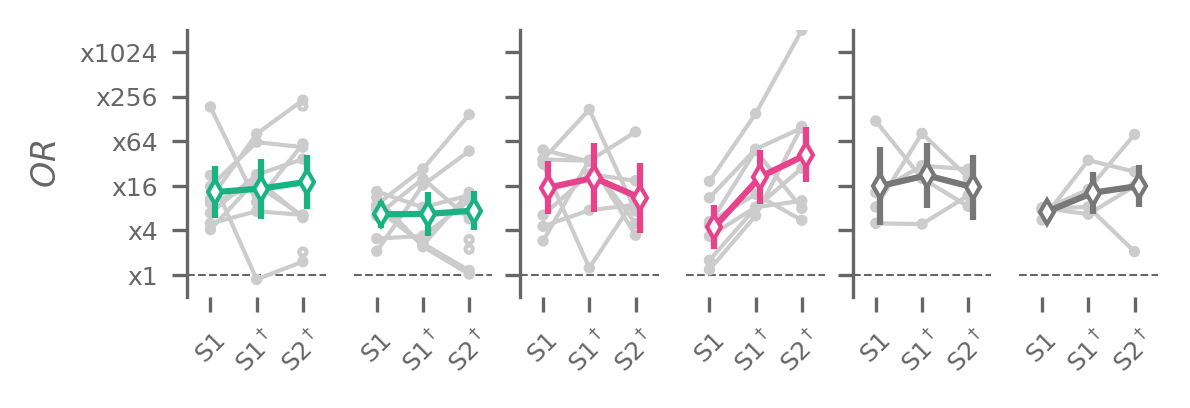

In [89]:
fig = figure_cm(COL1_5 - 1, 3, dpi=300)
axes = fig.subplots(1, 6)

print("Song NCM")
print("--------")
figure_S1("SO", "NCM", ax=axes[0])

print("DC NCM")
print("--------")
figure_S1("DC", "NCM", ax=axes[1])

print("SO HVC")
print("--------")
figure_S1("SO", "HVC", ax=axes[2])

print("DC HVC")
print("--------")
figure_S1("DC", "HVC", ax=axes[3])

print("SO CTRL")
print("--------")
figure_S1("SO", "CTRL", ax=axes[4])

print("DC CTRL")
print("--------")
figure_S1("DC", "CTRL", ax=axes[5])

for ax in axes:
    border(ax, 1)
    ax.set_xlim(-0.5, 2.5)

for ax in axes:
    draw_logor_axes_markers(smallest=-3, biggest=10, convert_log=False, ax=ax)
    ax.set_ylim(-1, 11)
    border(ax, 1)
    
for ax in axes[1::2]:
    border(ax)
    ax.set_yticks([])
    
for ax in axes[[2, 4]]:
    ax.tick_params(labelleft=False)

axes[0].set_ylabel("$OR$", fontsize=8)

for ax in axes:
    ax.set_xticks(
        [0, 1, 2],
        ["S1", "S1$^\dagger$", "S2$^\dagger$"],
        rotation=45,
        fontsize=6)

if SAVE_FIGS:
    fig.savefig(savedir("figS1.svg"), format="svg", bbox_inches="tight")
